# In this notebook we perform a time series analysis of the [brazilian Ibovespa index](https://finance.yahoo.com/quote/%5EBVSP/history/) , spanning a range from 249 trading days. Ir order to look for trends in the prices we apply the moving averege, exponential averege and double exponential averege algorithms. And we apply the Dickey-Fuller test to check if there is any stationary behavior.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


import statsmodels.tsa.api as smt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
IBOV = pd.read_csv('/content/BVSP.csv')

In [6]:
IBOV

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-04-05,115262.000000,117668.00000,115262.000000,117518.000000,117518.000000,7245100
1,2021-04-06,117519.000000,118213.00000,117176.000000,117499.000000,117499.000000,6800800
2,2021-04-07,117499.000000,118303.00000,116748.000000,117624.000000,117624.000000,0
3,2021-04-08,117624.000000,118850.00000,117486.000000,118313.000000,118313.000000,8778200
4,2021-04-09,118313.000000,118643.00000,117336.000000,117670.000000,117670.000000,7739400
...,...,...,...,...,...,...,...
245,2022-03-29,118740.000000,120900.00000,118740.000000,120014.000000,120014.000000,12931900
246,2022-03-30,120013.000000,120531.00000,119775.000000,120260.000000,120260.000000,10893300
247,2022-03-31,120261.000000,120880.00000,119999.000000,119999.000000,119999.000000,11202100
248,2022-04-01,120001.000000,121579.00000,120001.000000,121570.000000,121570.000000,13780900


In [7]:
IBOV.shape

(250, 7)

In [10]:
IBOV.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [12]:
drop_cols = ['Adj Close', 'Volume']
IBOV.drop(drop_cols, axis=1, inplace=True)

In [13]:
IBOV

,Date,Open,High,Low,Close
0,2021-04-05,115262.000000,117668.00000,115262.000000,117518.000000
1,2021-04-06,117519.000000,118213.00000,117176.000000,117499.000000
2,2021-04-07,117499.000000,118303.00000,116748.000000,117624.000000
3,2021-04-08,117624.000000,118850.00000,117486.000000,118313.000000
4,2021-04-09,118313.000000,118643.00000,117336.000000,117670.000000
...,...,...,...,...,...
245,2022-03-29,118740.000000,120900.00000,118740.000000,120014.000000
246,2022-03-30,120013.000000,120531.00000,119775.000000,120260.000000
247,2022-03-31,120261.000000,120880.00000,119999.000000,119999.000000
248,2022-04-01,120001.000000,121579.00000,120001.000000,121570.000000


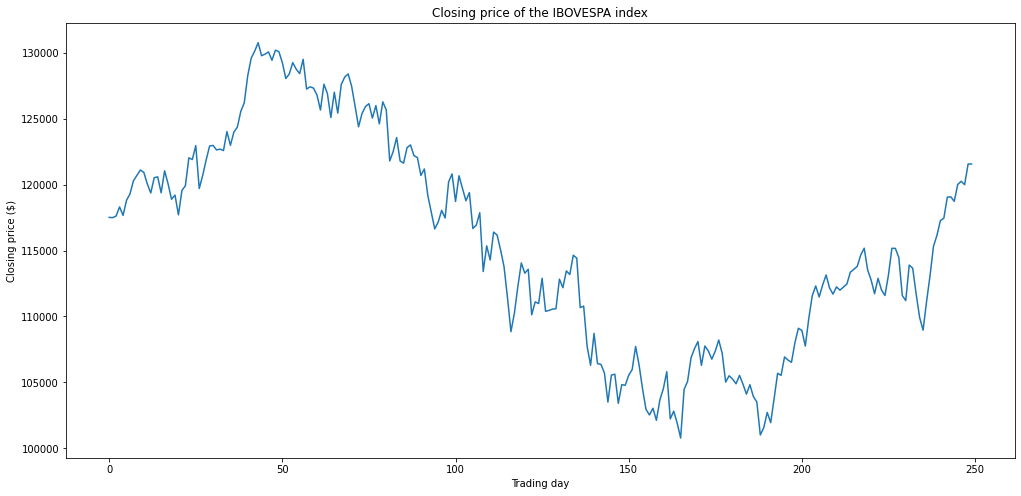

In [14]:
plt.figure(figsize=(17, 8))
plt.plot(IBOV.Close)
plt.title('Closing price of the IBOVESPA index')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

# **Moving averege**
The moving average approach states that the next observation is the mean of all past observations. The moving average can be used to identify interesting trends in the data. We can define a window to apply the moving average model to smooth the time series, and highlight different trends.

In [30]:
# First we define the moving averege function to be applied to our dataset.

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    # Compute the mean value in a specified window
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

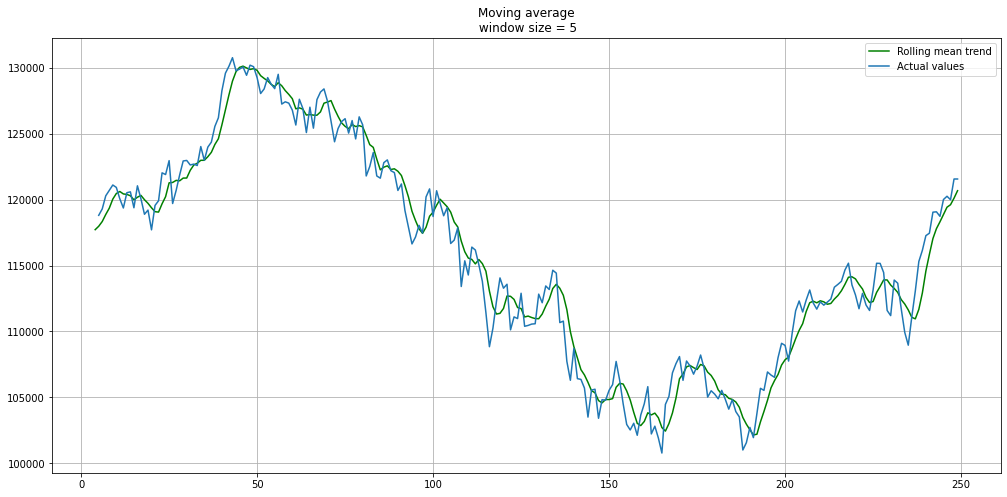

In [22]:
# Smoothig with 5 days
plot_moving_average(IBOV.Close, 5)

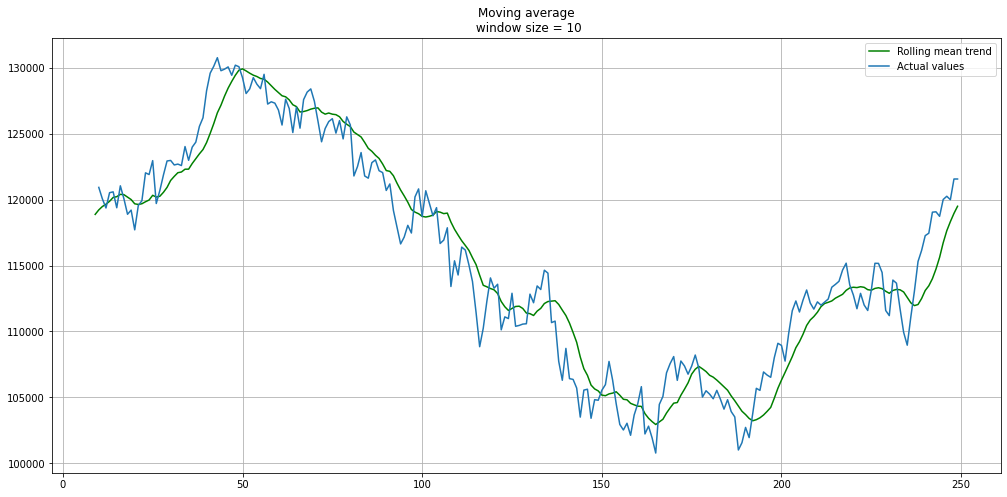

In [25]:
# Smoothig with 10 days
plot_moving_average(IBOV.Close, 10)

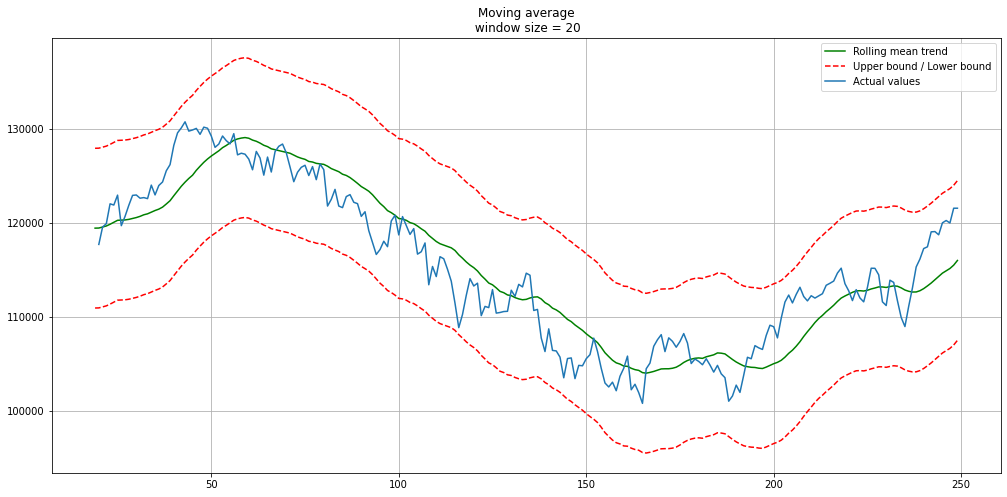

In [31]:
#Plotting with the confidence intervals in a window of 20 days
plot_moving_average(IBOV.Close, 20, plot_intervals=True)

# **Exponential Smoothing**
Exponential smoothing uses a similar logic to moving average, but this time, a different decreasing weight is assigned to each observations. In other words, less importance is given to observations as we move further from the present.
Mathematically, exponential smoothing is expressed as:
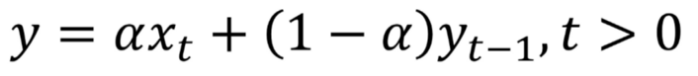

where alpha is a smoothing factor.

In [32]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [33]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

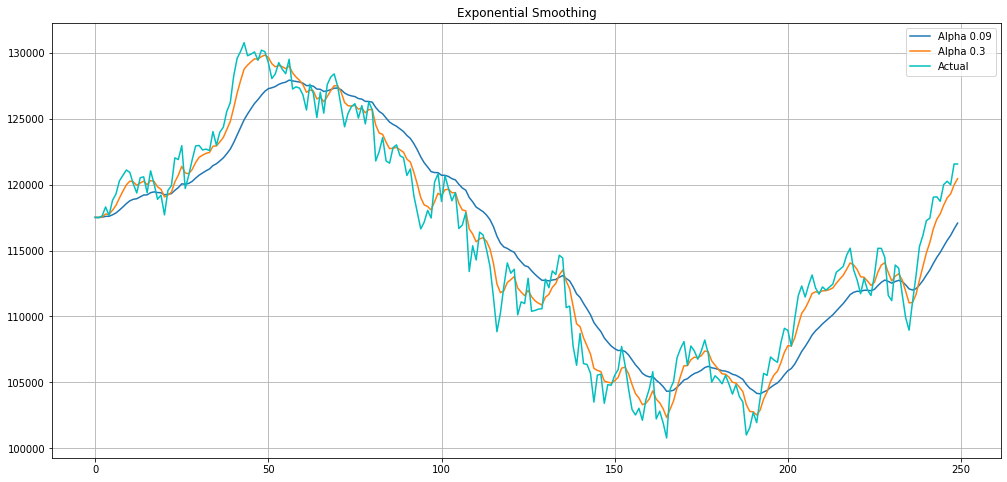

In [38]:
plot_exponential_smoothing(IBOV.Close, [0.09, 0.3])

# **Double Exponential Smoothing**
Double exponential smoothing is used when there is a trend in the time series. In that case, we use this technique, which is simply a recursive use of exponential smoothing twice.
Mathematically:
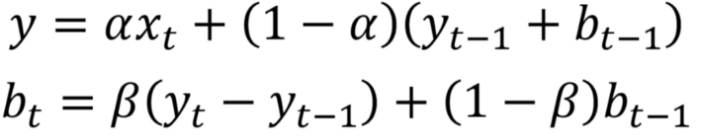

where beta is the trend smoothing factor

In [39]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [40]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

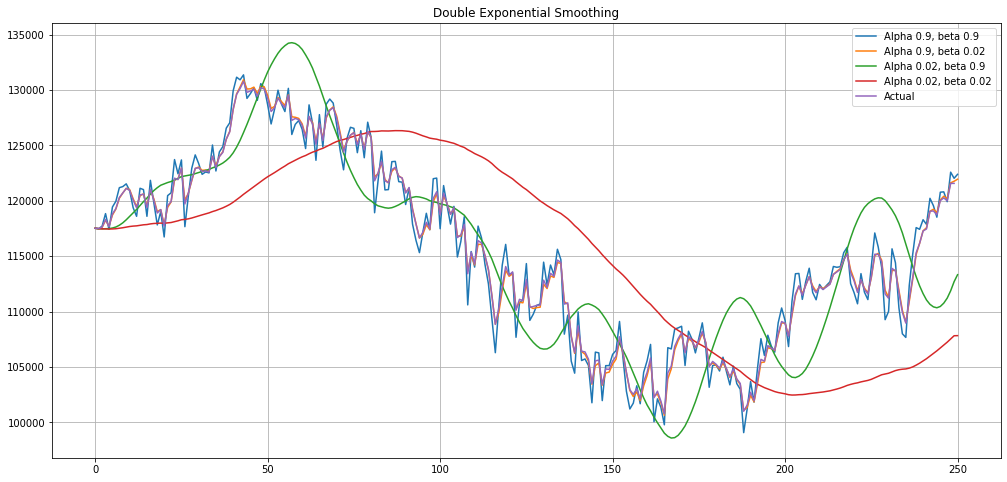

In [41]:
plot_double_exponential_smoothing(IBOV.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# **Stationarity**
A time series is said to be stationary if its statistical properties do not change over time. In other words, the variance and mean are constant. To test if a time series is stationarity one can use the [Dickey-Fuller](https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/) test.

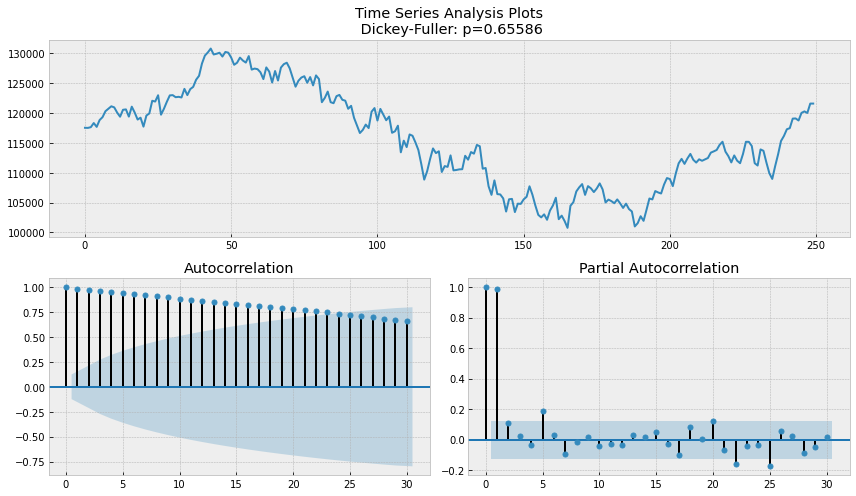

In [44]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(IBOV.Close, lags=30)